In [2]:
import numpy as np
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/recosys/u.data', sep = '\t', names = r_cols, encoding = 'latin-1')

ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

In [3]:
from sklearn.utils import  shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state = 1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

## Model 설계

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

K = 200   #잠재요인의 수
mu = ratings_train.rating.mean()    #전체 평균 계산
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1      #사용자 아이디와 영화 아이디의 최댓값, 나중에 embedding에 사용

def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))      #y_true, y_pred는 신경망에서 실제값, 예측값을 나타내는 TensorFlow/Keras의 표준 변수

user = Input(shape = (1,))
item = Input(shape = (1,))
P_embedding = Embedding(M,K, embeddings_regularizer = l2())(user)   #사용자 Embedding
Q_embedding = Embedding(N,K, embeddings_regularizer = l2())(item)   #아이템 Embedding
user_bias = Embedding(M,1, embeddings_regularizer = l2())(user)
item_bias = Embedding(N,1, embeddings_regularizer = l2())(item)

from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])


In [23]:
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs = [user, item], outputs = R)
model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics = [RMSE]
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 1, 200)               188800    ['input_11[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, 1, 200)               336600    ['input_12[0][0]']            
                                                                                            

### Model Fit

In [24]:
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values],
    y=ratings_train.rating.values - mu,
    epochs=65,
    batch_size=512,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/65
147/147 [==============================] - 18s 115ms/step - loss: 5.4047 - RMSE: 1.1252 - val_loss: 5.2790 - val_RMSE: 1.1253
Epoch 2/65
147/147 [==============================] - 16s 106ms/step - loss: 5.1594 - RMSE: 1.1244 - val_loss: 5.0410 - val_RMSE: 1.1245
Epoch 3/65
147/147 [==============================] - 15s 103ms/step - loss: 4.9282 - RMSE: 1.1237 - val_loss: 4.8166 - val_RMSE: 1.1238
Epoch 4/65
147/147 [==============================] - 15s 103ms/step - loss: 4.7101 - RMSE: 1.1230 - val_loss: 4.6049 - val_RMSE: 1.1230
Epoch 5/65
147/147 [==============================] - 15s 103ms/step - loss: 4.5046 - RMSE: 1.1221 - val_loss: 4.4055 - val_RMSE: 1.1224
Epoch 6/65
147/147 [==============================] - 15s 103ms/step - loss: 4.3107 - RMSE: 1.1214 - val_loss: 4.2174 - val_RMSE: 1.1217
Epoch 7/65
147/147 [==============================] - 15s 103ms/step - loss: 4.1277 - RMSE: 1.1207 - val_loss: 4.0399 - val_RMSE: 1.1209
Epoch 8/65
147/147 [=====================

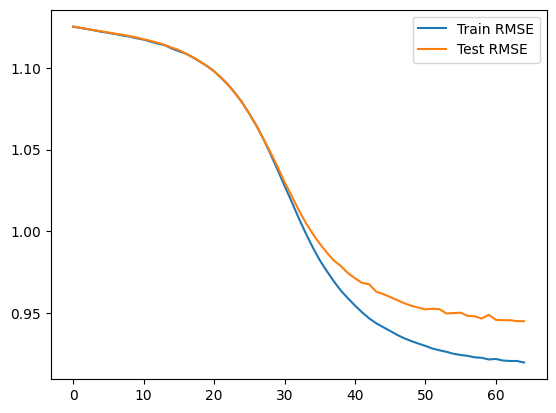

In [25]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = "Train RMSE")
plt.plot(result.history['val_RMSE'], label = "Test RMSE")
plt.legend()
plt.show()

### Prediction

In [27]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

1/1 [==============================] - 0s 255ms/step
Actuals: 
        user_id  movie_id  rating
53670      345       715       4
77110       92       998       2
69323      934       195       4
85968      586       423       2
30243      336       383       1
43868      654       678       4

Predictions: 
 [[3.4797277]
 [2.8443956]
 [3.9904666]
 [3.6987407]
 [2.0264702]
 [2.8835802]]
